# Projet "Risque de Crédit"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pprint import pprint

%matplotlib inline

## 1. Visualisation des données

In [2]:
df_map = pd.DataFrame.from_csv('data/20160630_CDS_Id_Mapping.csv', sep=';', index_col='CDS_Id')
df_cds = pd.DataFrame.from_csv('data/20160630_ITRAXX5Y.csv', sep=';', index_col='Date')

In [3]:
print 'data/20160630_CDS_Id_Mapping.csv :\n'
print df_map.head(3)
print ''
print 'data/20160630_ITRAXX5Y.csv :\n'
print df_cds.head(3)

data/20160630_CDS_Id_Mapping.csv :

                Name
CDS_Id              
261            Total
238     Saint-Gobain
570         Barclays

data/20160630_ITRAXX5Y.csv :

              Name  CDS_Id   Y05
Date                            
2003-07-23  ITRAXX       2  68.0
2003-07-24  ITRAXX       2  63.0
2003-07-25  ITRAXX       2  63.0


In [4]:
from collections import defaultdict

In [5]:
dc_map = defaultdict(list)
for _id, _name in df_map.itertuples():
    dc_map[_name].append(_id)

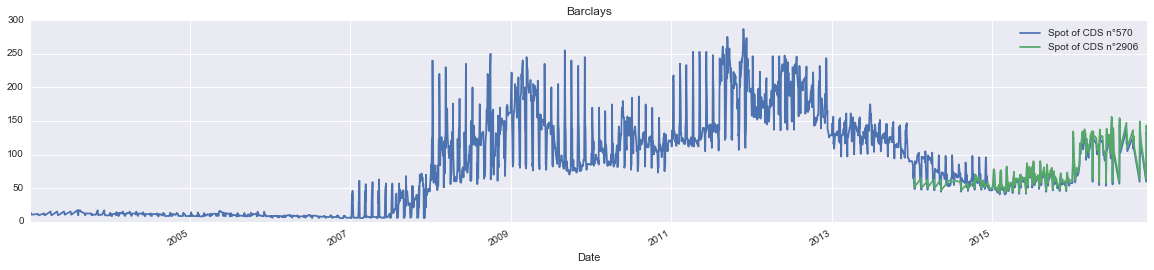

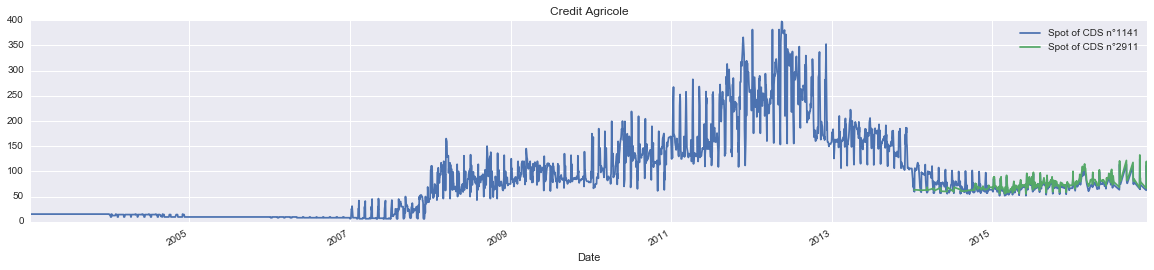

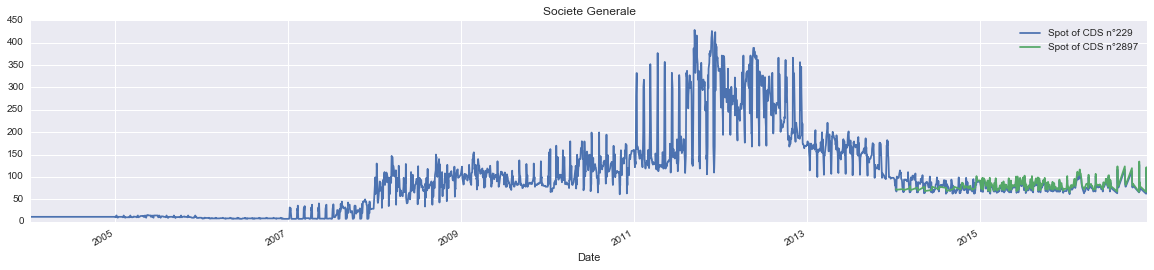

In [6]:
_names = ['Barclays', 'Credit Agricole', 'Societe Generale']
for _name in _names:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    for _i, _id in enumerate(dc_map[_name]):
        df_cds.loc[df_cds.loc[:, 'CDS_Id'] == _id, 'Y05'].plot(
            title = _name
            , ax = axes
            , label = 'Spot of CDS n°' + str(_id))
    plt.legend()
    plt.show()

On remarque un bouleversement des valeurs des CDS au cours de l'année 2007... quel hasard !

## 2. Analyse des rendements des CDS

L'article sur lequel porte notre projet traite des distributions des rendements des actifs. Avant d'appliquer les méthodes décrites dans ce dernier, nous devons transformer nos données de sorte à n'avoir à travailler qu'avec des rendements d'actifs (ici des CDS) sur lesquels on construira à terme notre porte-feuille d'actions optimisé au sens de Malevergne et Sornette.

In [7]:
dc_returns = {}
for _id in df_map.index.values:
    dc_returns[_id] = (
            df_cds.loc[df_cds.loc[:, 'CDS_Id'] == _id, 'Y05'].diff()    # absolute return...
            / df_cds.loc[df_cds.loc[:, 'CDS_Id'] == _id, 'Y05'].shift() # ... got normalized
        )

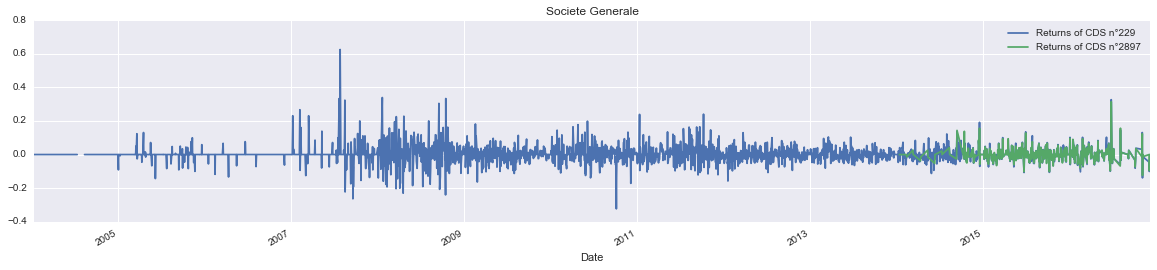

In [8]:
_names = ['Societe Generale']
for _name in _names:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    for _id in dc_map[_name]:
        dc_returns[_id].plot(
            title = _name
            , ax = axes
            , label = 'Returns of CDS n°' + str(_id))
    plt.legend()
    plt.show()

In [9]:
dc_returns = { key: df[df.index >= '2008-01-01'] for key, df in dc_returns.iteritems() }

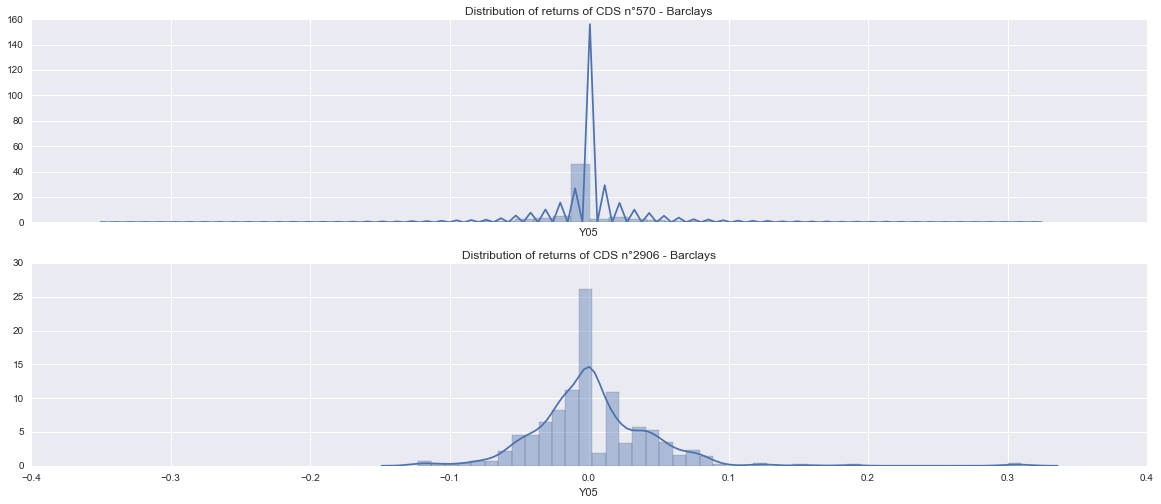

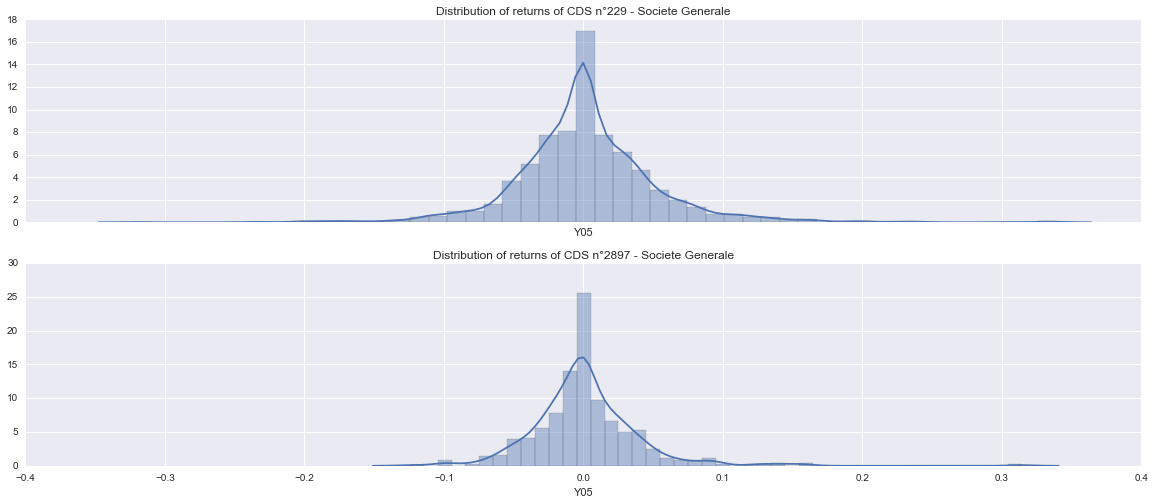

In [10]:
_names = ['Barclays', 'Societe Generale']
for _name in _names:
    _n = len(dc_map[_name])
    fig, axes = plt.subplots(nrows=_n, ncols=1, figsize=(20, 4*_n), sharex=True)
    plt.subplots_adjust(top=0.9)
    for _i, _id in enumerate(dc_map[_name]):
        try:
            ax = axes[_i]
        except TypeError:
            ax = axes
        df = dc_returns[_id]
        ax.set_title(u"Distribution of returns of CDS n°{} - {}".format(_id, _name))
        sns.distplot(df[df == df], ax = ax)
    plt.show()

La distribution des rendements n'est pas du tout gaussienne.

## 3. Transformation des rendements en variables gaussiennes

On implante ici la technique exposée par les auteurs dans la section 2.

In [11]:
from scipy.special import erfinv
from math import sqrt, isinf

In [12]:
def cdf(x, cdf_df):
    indexes = cdf_df.index.searchsorted(x)
    try:
        index = indexes[0]
    except IndexError:
        index = indexes
        
    if index == len(cdf_df):
        index = index-1
        i0 = i1 = cdf_df.index[index]
    elif index == 0:
        i0 = i1 = cdf_df.index[index]
    else:
        i0, i1 = cdf_df.index[index-1], cdf_df.index[index]
        if x-i0 < i1-x:
            index = index-1
    
    res = cdf_df.iloc[index]
    if res < 0 and isinf(res):
        return 0
    elif res > 0 and isinf(res):
        return 1
    else:
        return res

In [13]:
dc_gaussian_returns = {}
for _id, _df in dc_returns.iteritems():
    new_df = _df[1:].sort_values()
    new_df.append(new_df.iloc[-1:])   # Unbiased CDF, please
    cum_dist = np.linspace(0.,1.,len(new_df))
    cdf_df = pd.Series(cum_dist, index=new_df)
    dc_gaussian_returns[_id] = _df.map(lambda x: sqrt(2)*erfinv(2*cdf(x, cdf_df)-1))

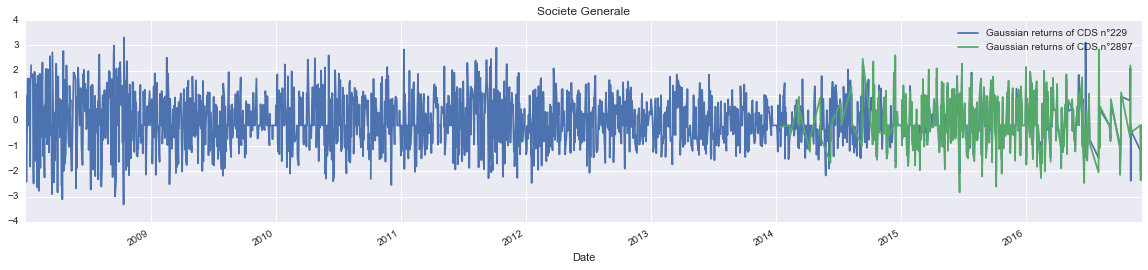

In [14]:
_names = ['Societe Generale']
for _name in _names:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    for _id in dc_map[_name]:
        dc_gaussian_returns[_id].plot(
            title = _name
            , ax = axes
            , label = 'Gaussian returns of CDS n°' + str(_id))
    plt.legend()
    plt.show()

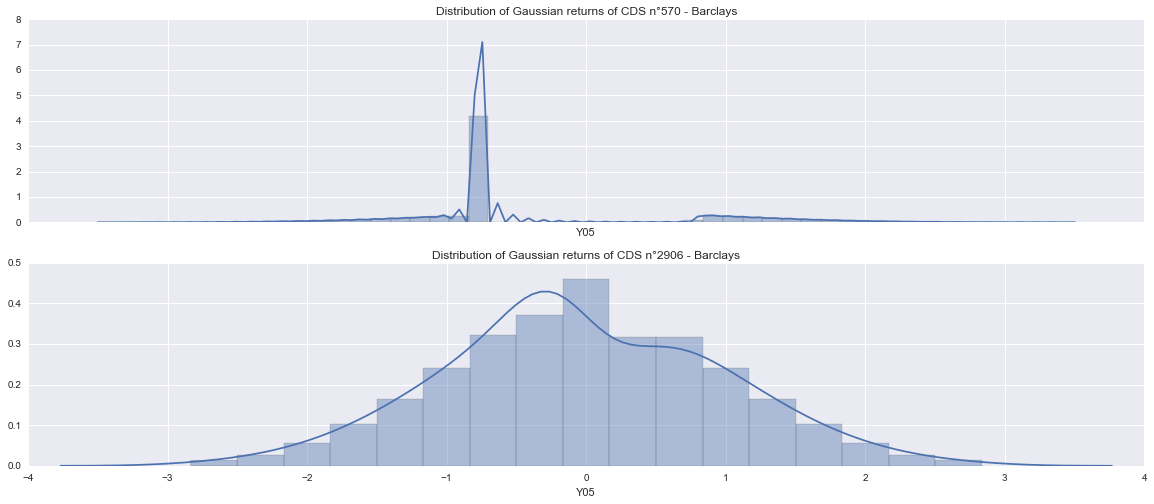

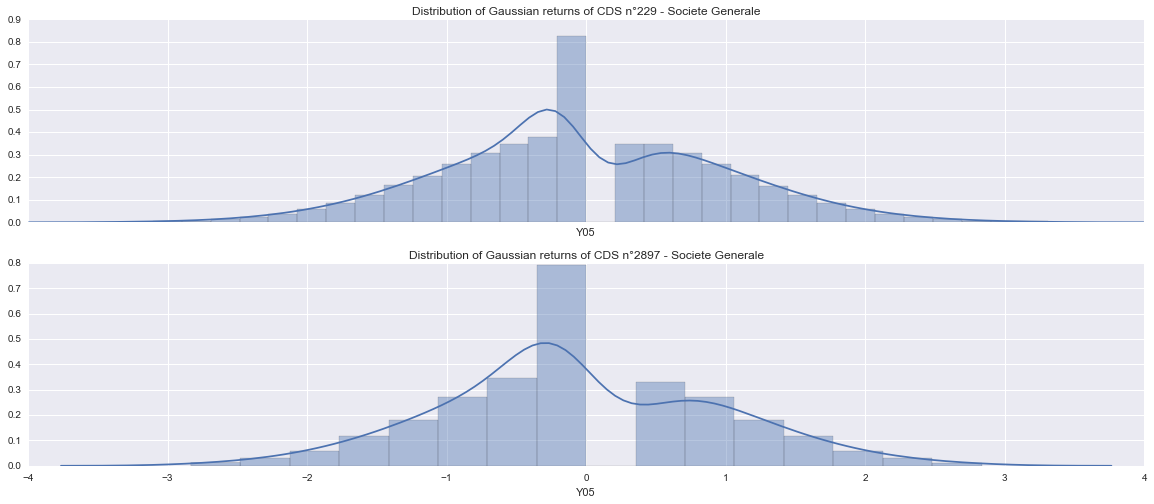

In [15]:
_names = ['Barclays', 'Societe Generale']
for _name in _names:
    _n = len(dc_map[_name])
    fig, axes = plt.subplots(nrows=_n, ncols=1, figsize=(20, 4*_n), sharex=True)
    for _i, _id in enumerate(dc_map[_name]):
        try:
            ax = axes[_i]
        except TypeError:
            ax = axes
        df = dc_gaussian_returns[_id]
        df = df[df != 0]
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[df == df]
        ax.set_title(u"Distribution of Gaussian returns of CDS n°{} - {}".format(_id, _name))
        sns.distplot(df, ax = ax)
    plt.show()

On a des distributions gaussiennes _modulo_ les non-linéarités plus ou moins importantes apparaissant en $0$.

## 4. Paramétrisation par une distribution de Weibull modifiée

On cherche dans cette partie à trouver les paramètres $c$ et $\chi$ permettant à nos rendements de _fitter_ un éléments de la classe des _modified Weibull distributions_ exposée dans la section 3. Notre objectif est double :

 - avoir accès aux paramètres $c$ et $\chi$ pour espérer appliquer l'optimisation de porte-feuille de la partie 6;
 - améliorer notre transformation, avant de faire tourner des tests quantitatifs de gaussianité, qui seraient catastrophiques à cause de nos problèmes autour de 0.

Nous allons opérer à la paramétrisation en utilisant la méthode non-linéaire des moindres carrés.

In [16]:
from scipy.optimize import curve_fit
from math import pi, exp

In [17]:
def smw_pde_scalar(x, c, chi):
    """Symmetric Modified Weibull PDE (Scalar)"""
    res = c/(2*sqrt(pi)*chi**(c/2))*abs(x)**(c/2-1)*exp(-(abs(x)/chi)**c)
    return res

def smw_pde(x, c, chi): 
    """Symmetric Modified Weibull PDE (Vector)"""
    return np.vectorize(lambda t: smw_pde_scalar(t, c, chi))(x)

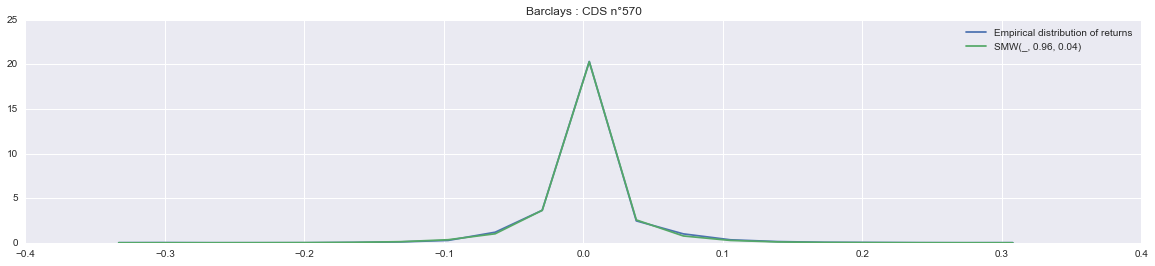

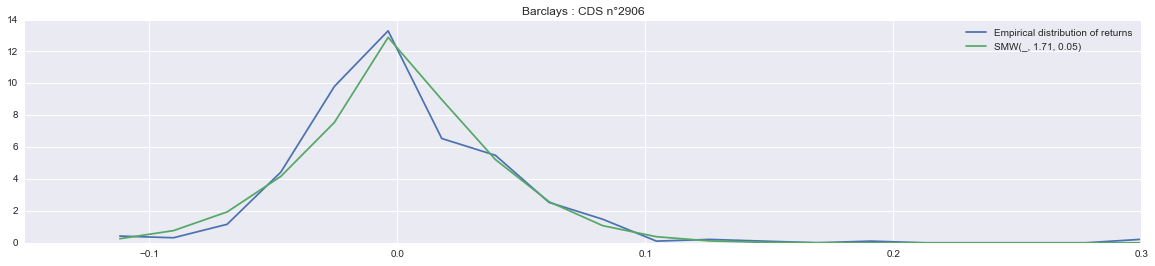

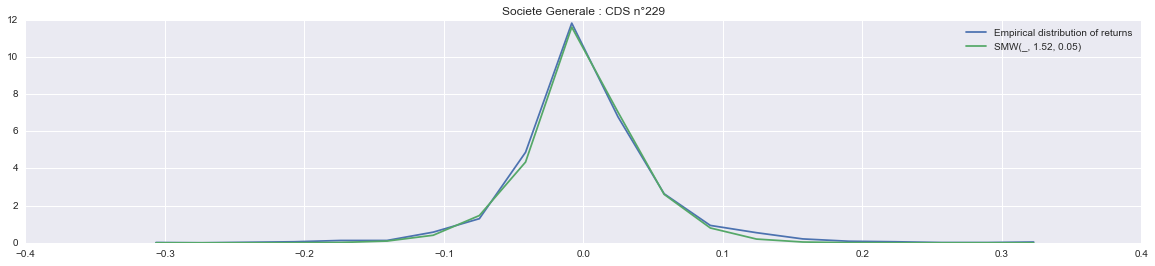

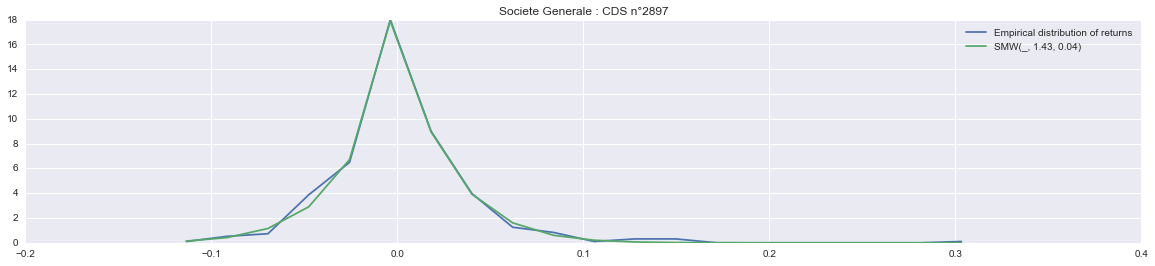

In [18]:
_names = ['Barclays', 'Societe Generale']
for _name in _names:
    for _id in dc_map[_name]:
        df = dc_returns[_id]
        df.replace([np.inf, -np.inf], np.nan)
        df = df[df == df]
        ydata, x = np.histogram(df.values, bins=20, normed=True)
        xdata = (x[:-1] + x[1:])/2
        (c, chi), _ = curve_fit(smw_pde, xdata, ydata)
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.set_title(u'{} : CDS n°{}'.format(_name, _id))
        ax.plot(xdata, ydata, label='Empirical distribution of returns')
        ax.plot(xdata, smw_pde(xdata, c, chi), label='SMW(_, {:.2f}, {:.2f})'.format(c, chi))
        plt.legend()
        plt.show()

OK, ça a l'air pas mal !

## 5. Transformation en variable gaussienne à partir de la paramétrisation Weibull

On implante ici la sous-section 3.2, et on prépare le terrain pour la suite en gardant sous le bras les valeurs des paramètres récupérés. On commence ainsi par stocker ces derniers.

In [19]:
smw_params = {}
for _id, _df in dc_returns.iteritems():
    _df = dc_returns[_id]
    _df.replace([np.inf, -np.inf], np.nan)
    _df = _df[_df == _df]
    ydata, x = np.histogram(_df.values, bins=20, normed=True)
    xdata = (x[:-1] + x[1:])/2
    smw_params[_id] = curve_fit(smw_pde, xdata, ydata)[0]

In [20]:
dc_gaussian_returns_bis = {}
for _id, _df in dc_returns.iteritems():
    c, chi = smw_params[_id]
    dc_gaussian_returns_bis[_id] = _df.map(lambda x: np.sign(x)*sqrt(2)*(abs(x)/chi)**(c/2))

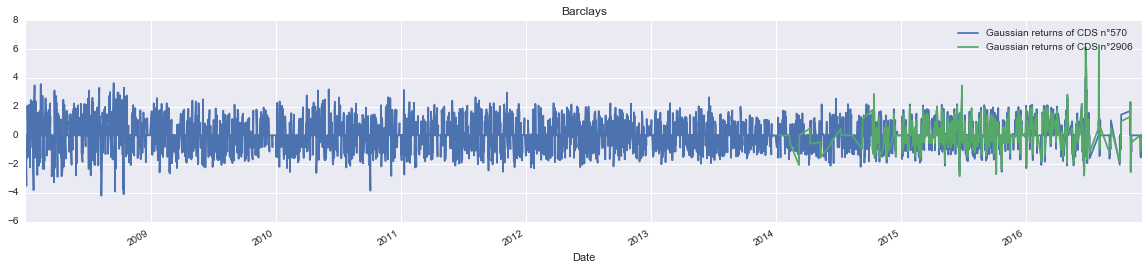

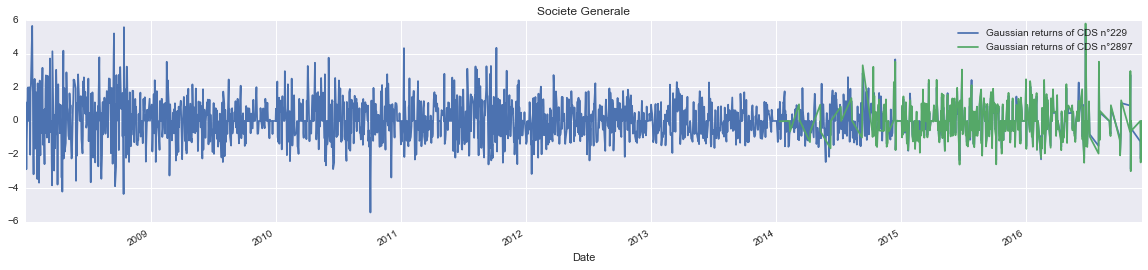

In [21]:
_names = ['Barclays', 'Societe Generale']
for _name in _names:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    for _id in dc_map[_name]:
        dc_gaussian_returns_bis[_id].plot(
            title = _name
            , ax = axes
            , label = 'Gaussian returns of CDS n°' + str(_id))
    plt.legend()
    plt.show()

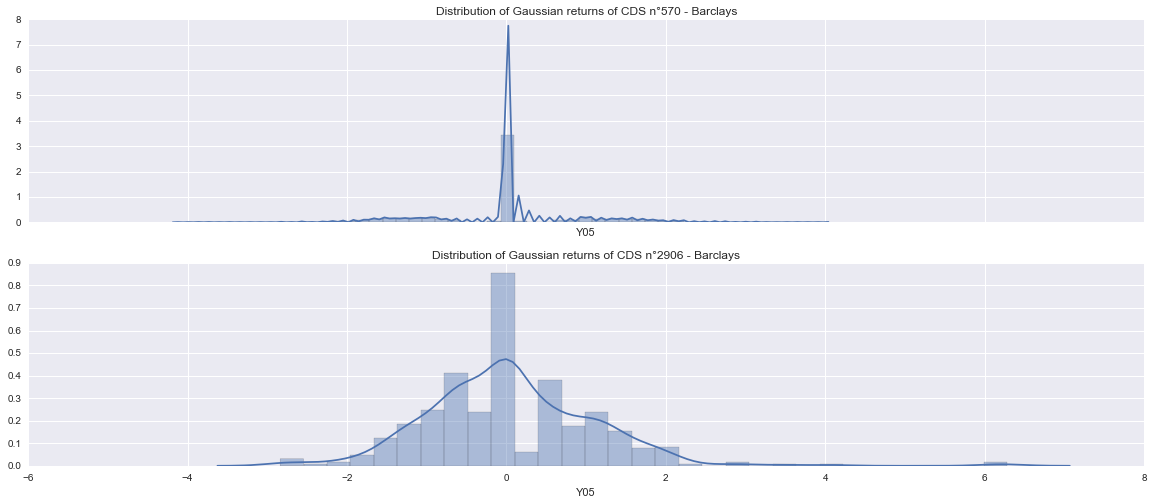

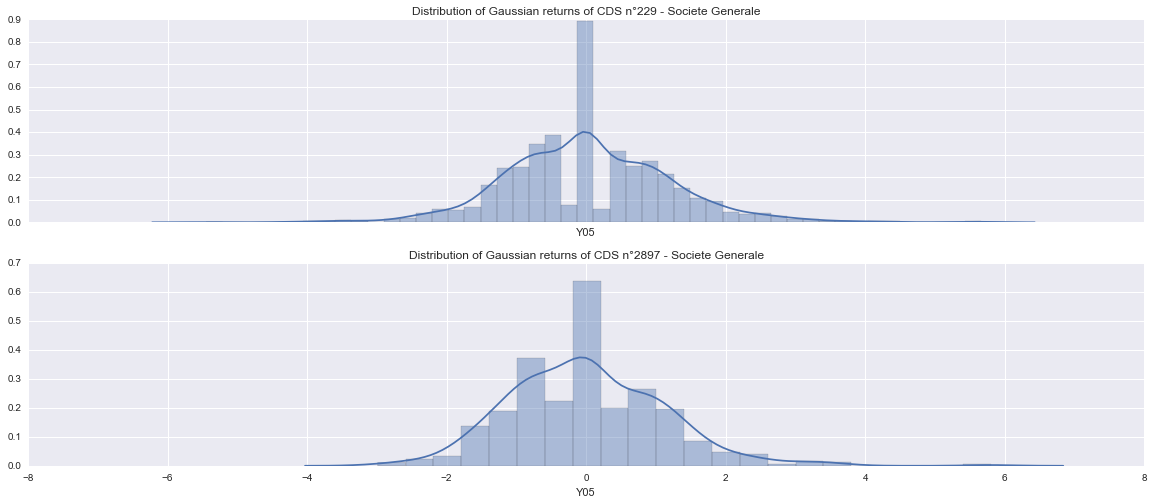

In [22]:
_names = ['Barclays', 'Societe Generale']
for _name in _names:
    _n = len(dc_map[_name])
    fig, axes = plt.subplots(nrows=_n, ncols=1, figsize=(20, 4*_n), sharex=True)
    for _i, _id in enumerate(dc_map[_name]):
        try:
            ax = axes[_i]
        except TypeError:
            ax = axes
        df = dc_gaussian_returns_bis[_id]
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[df == df]
        ax.set_title(u"Distribution of Gaussian returns of CDS n°{} - {}".format(_id, _name))
        sns.distplot(df, ax = ax)
    plt.show()

Ici, les problèmes de continuité en $0$ posent un problème plus visible, mais également plus symétrique en ce sens que la distribution trouvée s'écarte d'une distribution gaussienne par une "absorption" des valeurs autours de $0$ par $0$. Toujours est-il que le résultat, bien qu'en deçà de nos attentes, nous autorise tout de même à utiliser les paramètres $c$ et $\chi$ obtenus avec une confiance relativement bonne.

## 6. Estimation de la _Value at Risk_

On va rester avec le modèle simplifié supposant une relative symmétrie dans le comportement des rendements de sorte à diminuer le nombre de paramètres. La section 4 de l'article fait grand cas du paramètre $c$, et de la question de son unicité au travers du porte-feuille d'actifs. Essayons en premier lieu de voir dans quel cas nous sommes avec les données qui nous ont été fournies.

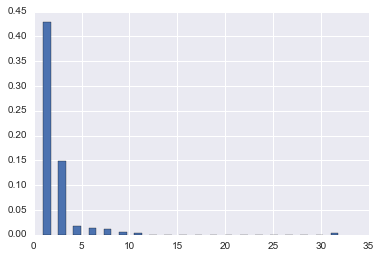

In [23]:
ydata, x = np.histogram([param[0] for param in smw_params.values()], bins=20, normed=True)
xdata = (x[:-1]+x[1:])/2
plt.bar(xdata, ydata)
plt.show()

Essayons de nous simplifier la vie en ne récupérant que les $50%$ d'actifs concentrés dans $1/20^è$ des valeurs de $c$, ce qui nous permettra de l'unifier pour notre application.

In [24]:
print x[0:2]

[ 0.19194907  1.77392182]


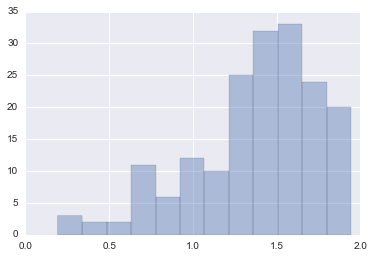

In [25]:
ydata, x = np.histogram([param[0] for param in smw_params.values() if param[0] < 2], normed=True)
xdata = (x[:-1]+x[1:])/2
sns.distplot([param[0] for param in smw_params.values() if param[0] < 2], kde=False)
plt.show()

In [26]:
len([param[0] for param in smw_params.values() if (param[0] > 1.2 and param[0] < 2)])

136

Prenons donc ces 136 CDS comme base de notre porte-feuille, en leur supposant un commun $c=1.5>1$. Ne pouvant pas décemment les supposer indépendants, on se réfère ici à la sous-sous-section 4.1.2 de l'article.

In [27]:
import src.portfolio
reload(src.portfolio)
from src.portfolio import Portfolio

In [28]:
def bool412(c):
    return (c > 1.2 and c < 2)

In [29]:
pf = Portfolio([_id for _id in smw_params.keys() if bool412(smw_params[_id][0])])

In [ ]:
pf.set_weights({_id: 1 for _id in pf.assets})

In [ ]:
df_pf_returns = pf.get_returns(dc_returns)

In [ ]:
df_pf_returns.plot(title = "Rendement d'un portefeuille homogène")
plt.show()